# Political Beliefs and Gender Gaps

[A recent article in the Financial Times](https://www.ft.com/content/29fd9b5c-2f35-41bf-9d4c-994db4e12998) suggests that among young people there is a growing gender gap in political alignment -- increasingly, more men than women identify as conservative.

[In last week's post](https://www.allendowney.com/blog/2024/01/28/is-the-ideology-gap-growing/), I tried to replicate this result using data from the General Social Survey. I found that there is a gender gap -- a difference of 5-10 percentage points in how male and female respondents classify themselves. But I found no evidence that the gap is growing.

However, several related questions remain:

* Is there a gap in party affiliation, and is it growing?

* Is there a gap in political beliefs, and is it growing?

I address the first pair of questions in [this companion notebook](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/party_gap.ipynb).

Now let's look at the second question.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/belief_gap.ipynb)

## Imports and Function Definitions

In [1]:
# Install empirical dist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.7):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [4]:
def plot_series_lowess(series, color, plot_series=True, frac=0.7, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [5]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Read the Data

In [6]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

In [7]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

In [8]:
download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_resampled.hdf")

'gss_pacs_resampled.hdf'

The HDF file contains three resamplings of the GSS data, with the keys `gss0`, `gss1`, and `gss2`. The resampled data correct for stratified sampling in the GSS survey design, and provide a coarse estimate of variability due to random sampling. I do development and testing with one resampling, then check that the results are consistent with the others.

In [9]:
gss = pd.read_hdf('gss_pacs_resampled.hdf', 'gss0')
gss.shape

(72390, 207)

## Quantifying Political Beliefs

To classify beliefs as conservative or liberal, I started with a list of about 120 core GSS questions that ask about political beliefs, broadly defined.
For each question, I identified the responses that were chosen more often by people who consider themselves conservative.

Then, I searched for questions with the biggest differences between the responses of liberals and conservatives. From those, I curated a list of fifteen questions that cover a diverse set of topics, with preference for questions that were asked most frequently over the years of the survey.

The topics that made the list are not surprising. They include economic issues like public spending on welfare and the environment; policy issues like the legality of guns, drugs, and pornography; as well as questions related to sex education and prayer in schools, capital punishment, assisted suicide, and (of course) abortion. The list also includes three of the questions we looked at in previous sections, related to open housing laws, women in politics, and homosexuality.

For the current purpose, we are not concerned with the wording of the questions; we only need to know that liberals and conservatives give different answers. But if you are curious, I'll put the questions at the end of this post.

Then, to estimate the conservatism of each respondent, I used Bayesian inference.
The details are in [this notebook](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/overton_irt.ipynb).

Here are the variable names and the responses chosen more often by conservatives.
Most of the questions are binary, but some allow a range of responses.

In [10]:
issue_dict = {
    "homosex": "Homosexuality",
    "cappun": "Capital punishment",
    "grass": "Legal cannabis",
    "abany": "Abortion",
    "prayer": "School prayer",
    "premarsx": "Premarital sex",
    "divlaw": "Divorce",
    "natfare": "Welfare spending",
    "natenvir": "Environment",
    "pornlaw": "Pornography",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
}

issue_names = issue_dict.values()

In [11]:
conservative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

In [12]:
questions = pd.DataFrame(dtype=float)

for varname in issue_dict:
    questions[varname] = gss[varname].isin(conservative_values[varname]).astype(float)
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan

In [13]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}
gss["polviews3"] = gss["polviews"].replace(recode_polviews)
gss["polviews3"].value_counts()

polviews3
Moderate        24157
Conservative    21573
Liberal         17203
Name: count, dtype: int64

In [14]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_color_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))

In [15]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100

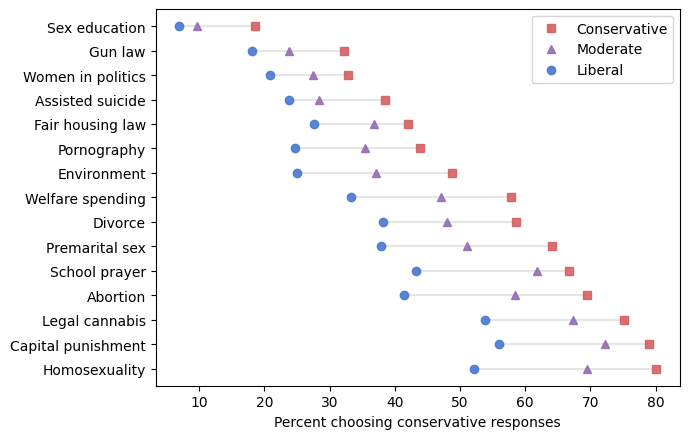

In [16]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_color_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")
savefig('belief_gap1.png')

Now let's estimate the number of conservative responses from each respondent.

In [17]:
from scipy.special import logit

ds = -logit(questions.mean().values)
ds

array([-0.81972919, -0.84499735, -0.73760238, -0.33819914, -0.36021497,
       -0.12978646,  0.03569997,  0.13342916,  0.49084731,  0.56139502,
        0.50968301,  0.77591968,  0.9310768 ,  1.09340157,  1.95613237])

In [18]:
from scipy.special import expit

es = np.linspace(-6, 6, 21)
E, D = np.meshgrid(es, ds)
P = expit(E - D)
Q = 1 - P
ns = P.sum(axis=0)

In [19]:
from scipy.stats import norm
from empiricaldist import Pmf

ps = norm.pdf(es, 0, 4)
prior = Pmf(ps, es)
prior.normalize()

1.4751408263256967

In [20]:
n, m = questions.shape
size = n, m, len(es)
res = np.empty(size)

In [21]:
a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [22]:
product = res.prod(axis=1) * prior.values
posterior = product / product.sum(axis=1)[:, None]
con = (posterior * ns).sum(axis=1)

We'll exclude people who answered fewer than 5 questions.

In [23]:
answered = questions.notna().sum(axis=1)
(answered >= 5).mean()

0.9038541234977207

In [24]:
gss["conservatism"] = pd.Series(con, gss.index)
gss.loc[answered < 5, "conservatism"] = np.nan
gss["conservatism"].describe()

count    65430.000000
mean         6.828167
std          3.223471
min          0.493615
25%          4.524223
50%          6.817152
75%          9.304221
max         14.475380
Name: conservatism, dtype: float64

## Conservatism Over Time

Following the analysis in the FT, I'll select people under 30.

In [25]:
subset = gss.query('age < 30')

Here's how the average number of conservative responses has changed over time.

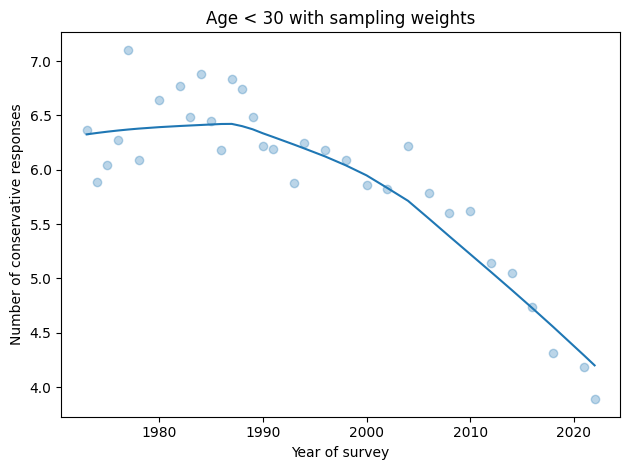

In [26]:
series = subset.groupby("year")["conservatism"].mean()

plot_series_lowess(series, color="C0", label="")
decorate(xlabel="Year of survey", 
         ylabel="Number of conservative responses",
         title='Age < 30 with sampling weights')
savefig('belief_gap2.png')

## Gender gap

The following figure shows conservatism over time, grouped by sex.

In [27]:
subset['sex'].value_counts()

sex
2.0    8496
1.0    7891
Name: count, dtype: int64

In [28]:
table = subset.pivot_table(index="year", columns="sex", values="conservatism", aggfunc='mean')

In [29]:
columns = [1, 2]
color_map = dict(zip(columns, ['C0', 'C1']))
label_map = dict(zip(columns, ['Male', 'Female']))

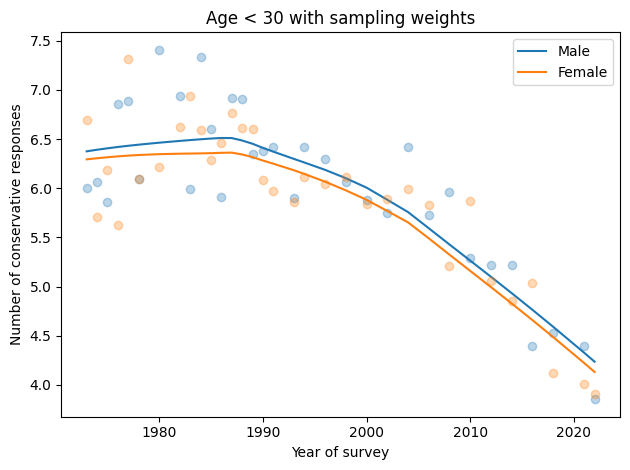

In [30]:
for column in columns:
    plot_series_lowess(table[column], color=color_map[column], label=label_map[column])

decorate(xlabel="Year of survey", 
         ylabel="Number of conservative responses",
         title='Age < 30 with sampling weights')
savefig('belief_gap3.png')

## Appendix: The Fifteen Questions

This appendix provides the wording of the fifteen questions from the General Social Survey that most distinguish liberals and conservatives, identified by topic and the GSS variable name.

* Homosexuality (homosex): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

* Capital punishment (cappun): Do you favor or oppose the death penalty for persons convicted of murder?

* Legal cannabis (grass): Do you think the use of marijuana should be made legal or not?

* Abortion (abany): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

* Prayer in public schools (prayer): The United States Supreme Court has ruled that no state or local government may require the reading of the Lord's Prayer or Bible verses in public schools. What are your views on this--do you approve or disapprove of the court ruling?

* Premarital sex (premarsx): There's been a lot of discussion about the way morals and attitudes about sex are changing in this country. If a man and woman have sex relations before marriage, do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

* Divorce (divlaw): Should divorce in this country be easier or more difficult to obtain than it is now?

* Spending on welfare (natfare) and the environment (natenvir): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount.
  1. Welfare

  2. Improving and protecting the environment

* Pornography (pornlaw): Which of these statements comes closest to your feelings about pornography laws? 

  1. There should be laws against the distribution of pornography whatever the age.

  2. There should be laws against the distribution of pornography to persons under 18.

  3. There should be no laws forbidding the distribution of pornography.

* Open housing law (racopen): Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on; which law would you vote for? 

  1. One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].

  2. The second law says that a homeowner cannot refuse to sell to someone because of their race or color.

* Assisted suicide (letdie1): When a person has a disease that cannot be cured, do you think Doctors should be allowed by law to end the patient's life by some painless means if the patient and his family request it?

* Women in politics (fepol): Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

* Gun control (gunlaw): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

* Sex education (sexeduc): Would you be for or against sex education in the public schools?

Here are the 10 questions from Chapter 11. They yield simular results.

In [31]:
conservative_values = {
    "fepol": [1],
    "fefam": [1, 2],
    "fepres": [2],
    "homosex": [1, 2, 3],
    "libhomo": [1],
    "spkhomo": [2],
    "colhomo": [5],
    "racopen": [1],
    "racpres": [2],
    "racmar": [1],
}

varnames = conservative_values.keys()